<a href="https://colab.research.google.com/github/pbplop29/Photogrammetry/blob/main/Photogrammetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handling the imports

In [55]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
from skimage import filters 
from google.colab.patches import cv2_imshow
import cv2
import matplotlib as mpl
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  

# Computing the Mapping/Scaling Factors 

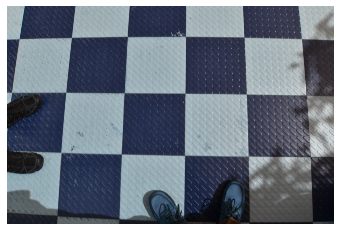

In [56]:
# Reading and plotting the calibration image 
image_name = 'map.JPG'
img = cv2.imread(image_name)
plt.axis('off')
plt.imshow(img)

In [57]:
# Handling the naming conventions, if we want to save the files
image_name_proper = image_name.rsplit( ".", 1 )[ 0 ]
image = skimage.io.imread(fname=image_name)
image_mask_name = image_name_proper + "---mask.JPG"
image_contours_name = image_name_proper + "---contours.JPG"
image_resized_name = image_name_proper + "--resized.JPG"
final_image_name = image_name_proper + "---final.JPG"

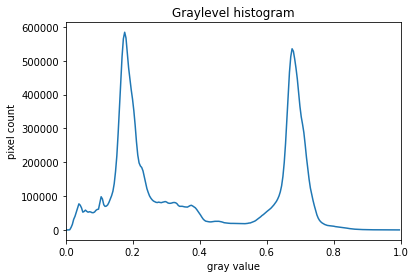

In [58]:
# Converting the Image to grayscale
gray_image = skimage.color.rgb2gray(img)
# Blur the image to denoise
blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)

# Finding the Optimal Threshold value

histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Graylevel histogram")
plt.xlabel("gray value")
plt.ylabel("pixel count")
plt.xlim(0, 1.0)
plt.show()

In [59]:
# Finding the optimum threshold value from above histogram
t = skimage.filters.threshold_otsu(blurred_image)
print("Found automatic threshold t = {}.".format(t))
t=t-0.15

Found automatic threshold t = 0.4376442014074442.


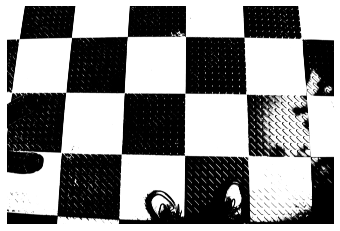

In [62]:
# Creating the threshold mask
binary_mask = blurred_image > t
fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap="gray")
plt.axis('off')
plt.savefig(image_mask_name,dpi=300*4.415,bbox_inches='tight',pad_inches = 0)
plt.show()

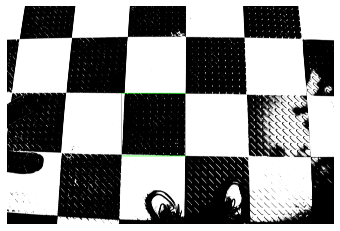

In [63]:
# Defining some simple functions for ease
def display(img):
    cv2_imshow(img)
def shape(img):
    print(img.shape)
def resize(img, width=100, height=100, inter=cv2.INTER_AREA):
    img = cv2.resize(img, (width,height), interpolation=inter)
    return img

# Finding the edges and plotting a contour around our calibration reference
img = cv2.imread(image_mask_name)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
edged = cv2.Canny(imgray, 30, 200,0)
dilate = cv2.dilate(thresh, None, iterations=1)
erode = cv2.erode(dilate, None, iterations=1)
contours, hierarchy = cv2.findContours(erode , cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
count = 0
for c in contours:
    area = cv2.contourArea(c)
    if area >img.shape[0]*img.shape[1]*0.50 or area < img.shape[0]*img.shape[1]*0.005:
        pass
    else:
      if count == 0:
        count=count+1
        pass
      else:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 10)
        cv2.circle(img, (x + w//2, y + h//2), 5, (0, 0, 255), 2)
        break
plt.axis('off')
plt.imshow(img)

In [64]:
# Finding the starting coordinates and width and height of the contour box
x,y,w,h

(2104, 1600, 1170, 1150)

In [65]:
# Tweaking the box for uniformity and exclusion of the whitespace observed
x = x+20
w = w-20


In [66]:
# Final starting coordinates and width and height of the contour boxs
x,y,w,h

(2124, 1600, 1150, 1150)

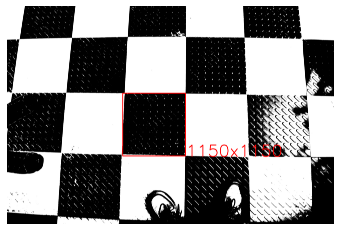

In [67]:
# Finding the pixel area covered by the calibration reference
img = cv2.imread(image_mask_name)
cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 15)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 10
color = (255, 0, 0)
thickness = 15
cv2.putText(img, str(w)+"x"+str(h),(x+w+10,y+h+10), font, 
                   fontScale, color, thickness)
#plt.savefig('map--pixes.JPG',dpi=300*4.415,bbox_inches='tight',pad_inches = 0)
plt.axis('off')
plt.imshow(img)

In [68]:
focal_length = 0.018
height = 1.37
distance_actual = 0.3
distance_on_lens1 = distance_actual * focal_length/height
print("Found distance on lens for height of 1.37m === {}.".format(distance_on_lens1))

Found distance on lens for height of 1.37m === 0.003941605839416057.


In [69]:
focal_length = 0.018
height = 1.5 
distance_actual = 0.3
distance_on_lens2 = distance_actual * focal_length/height
print("Found distance on lens for height of 1.5m === {}.".format(distance_on_lens2))

Found distance on lens for height of 1.5m === 0.0035999999999999995.


In [70]:
pxiels_in_case_1 = 1150
pixels_in_case_2 = 0      # We need to compute this

In [71]:
pixels_in_case_2 = int(distance_on_lens2*(pxiels_in_case_1)/distance_on_lens1)
print("Found the number of pixles representing 30cm at height of 1.5m === {}.".format(int(pixels_in_case_2)))

Found the number of pixles representing 30cm at height of 1.5m === 1050.


In [72]:
distance_per_pixel = distance_actual/pixels_in_case_2
print("Found the distance per pixel at height of 1.5m === {}.".format(distance_per_pixel))

Found the distance per pixel at height of 1.5m === 0.0002857142857142857.


# Perspective Foreshortening

In [73]:
angle_with_horizon = 26.56
angle_with_pole= 90-angle_with_horizon
print("Found the angle made by camera to pole === {}.".format(angle_with_pole))

Found the angle made by camera to pole === 63.44.


In [74]:
# https://www.scantips.com/lights/subjectdistance.html 

# The above site has a relationship for angle of camera and perspective multiplier

In [75]:
perspective_multiplier = 2.2365
print("Found the prespective multiplier === {}.".format(perspective_multiplier))

Found the prespective multiplier === 2.2365.


# Feature Extraction

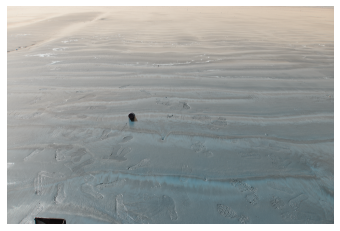

In [76]:
# Reading and plotting the problem image 
image_name = '1.JPG'
img = cv2.imread(image_name)
plt.axis('off')
plt.imshow(img)

In [77]:
# Handling the naming conventions, if we want to save the files
image_name_proper = image_name.rsplit( ".", 1 )[ 0 ]
image = skimage.io.imread(fname=image_name)
image_mask_name = image_name_proper + "---mask.JPG"
image_contours_name = image_name_proper + "---contours.JPG"
image_resized_name = image_name_proper + "--resized.JPG"
final_image_name = image_name_proper + "---final.JPG"

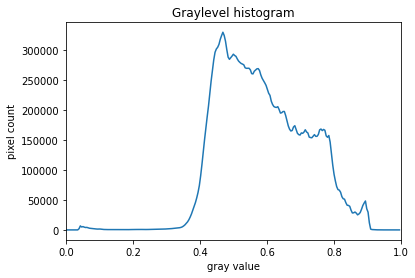

In [78]:
# Converting the Image to grayscale
gray_image = skimage.color.rgb2gray(img)
# Blur the image to denoise
blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)

# Finding the Optimal Threshold value

histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Graylevel histogram")
plt.xlabel("gray value")
plt.ylabel("pixel count")
plt.xlim(0, 1.0)
plt.show()

In [79]:
# Finding the optimum threshold value from above histogram
t = skimage.filters.threshold_otsu(blurred_image)
print("Found automatic threshold t = {}.".format(t))
t=t-0.25

Found automatic threshold t = 0.6093289280498433.


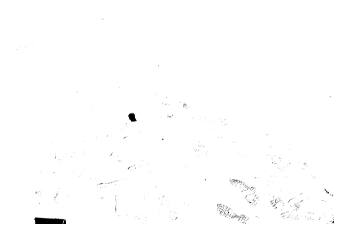

In [80]:
# Creating the threshold mask
binary_mask = blurred_image > t
fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap="gray")
plt.axis('off')
plt.savefig(image_mask_name,dpi=300*4.415,bbox_inches='tight',pad_inches = 0)
plt.show()

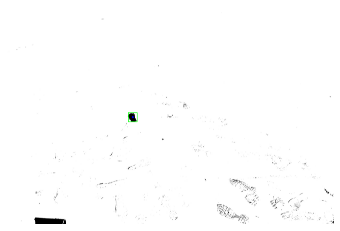

In [95]:
def display(img):
    cv2_imshow(img)
def shape(img):
    print(img.shape)
def resize(img, width=100, height=100, inter=cv2.INTER_AREA):
    img = cv2.resize(img, (width,height), interpolation=inter)
    return img

# input should be a grayscale image
imgx = cv2.imread(image_resized_name)
img = cv2.imread(image_mask_name)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
edged = cv2.Canny(imgray, 30, 200,0)
dilate = cv2.dilate(thresh, None, iterations=1)
erode = cv2.erode(dilate, None, iterations=1)
contours, hierarchy = cv2.findContours(erode , cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for c in contours:
    area = cv2.contourArea(c)
    if area >img.shape[0]*img.shape[1]*0.98 or area < img.shape[0]*img.shape[1]*0.00065:
        pass
    else:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 10)
        cv2.circle(img, (x + w//2, y + h//2), 10, (0, 0, 255), 15)

#cv2.imwrite(image_contours_name, img)
plt.axis('off')
plt.imshow(img)
